In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter, ParticleFilter_Sequential
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

float64


Initialisation of a twin experiment. 

In [2]:
signal_params = ConfigDict(KS_params_SALT)
ensemble_params = ConfigDict(KS_params_SALT)
signal_params.update(E=1,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_params.update(E=128,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')

Now we specify the models, by calling the class.

In [3]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

multinomial, systematic, no_resampling, none, default


In [ ]:
observation_spatial_frequency = 32
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.1
number_of_observations_time = 32#ensemble_model.params.nt#32
observation_temporal_frequency = int(ensemble_model.params.nt/number_of_observations_time)

print(observation_locations)
pf_systematic = ParticleFilter_Sequential(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    ess_threshold= 0.5,
    resampling="systematic",#'default',
    observation_locations = observation_locations,
)

[  0  32  64  96 128 160 192 224]


In [5]:
key = jax.random.PRNGKey(0)
da_steps = number_of_observations_time
initial_weights = jnp.ones(ensemble_params.E) / ensemble_params.E
final, all = pf_systematic.run(initial_ensemble, initial_weights, initial_signal, da_steps,key) #the final input is scan length? 

ESS: Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>


In [6]:
for i, arr in enumerate(all):
    print(f"Shape of all[{i}]: {arr.shape}") 

# if ParticleFilter_Sequential then we have 4 outputs, 

Shape of all[0]: (32, 128, 256)
Shape of all[1]: (32, 128)
Shape of all[2]: (32, 1, 256)
Shape of all[3]: (32, 1, 256)


Put in the initial condition.

In [7]:
particles =jnp.concatenate([initial_ensemble[None,...], all[0]], axis=0)
signal = jnp.concatenate([initial_signal[None,...], all[2]], axis=0)
observations = jnp.concatenate([initial_signal[None,...], all[3]], axis=0)
observations = all[2][:,:, observation_locations]
print(observations.shape)
print(particles.shape)

(32, 1, 8)
(33, 128, 256)


In [8]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles[da_step,:,:].T, color='b',label='particles',linewidth=0.1)
    if da_step > 0:
        plt.plot(signal_model.x[observation_locations], observations[da_step-1,0,:], 'ro',label='observations')
    plt.show()

interact(plot, da_step=(0, da_steps))

interactive(children=(IntSlider(value=16, description='da_step', max=32), Output()), _dom_classes=('widget-int…

<function __main__.plot(da_step)>

In [9]:
ensemble_params_1 = ConfigDict(KS_params_SALT)
ensemble_params_1.update(E=128,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_model_1 = ETD_KT_CM_JAX_Vectorised(ensemble_params_1)
initial_ensemble_1 = initial_condition(ensemble_model_1.x, ensemble_params_1.E, ensemble_params_1.initial_condition)
key2 = jax.random.PRNGKey(0) # sometimes the key matters!
pf_systematic_1 = ParticleFilter(
    n_particles = ensemble_params_1.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model_1,
    signal_model = signal_model,
    sigma = observation_noise,
    resampling='none',
    observation_locations = observation_locations,
)

final_1, all_1 = pf_systematic_1.run(initial_ensemble_1, initial_signal, da_steps, key2) #the final input is scan length? 


In [10]:
particles_1 =jnp.concatenate([initial_ensemble_1[None,...], all_1[0]], axis=0)
signal_1 = jnp.concatenate([initial_signal[None,...], all_1[1]], axis=0)
observations_1 = jnp.concatenate([initial_signal[None,...], all_1[2]], axis=0)

def new_plot(da_step):
    plt.figure(figsize=(10, 5))

    plt.plot(signal_model.x, particles[da_step,:,:].T, color='b',label='particles',linewidth=0.1)
    plt.plot(signal_model.x, signal[da_step,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles_1[da_step,:,:].T, color='k',label='particles_no_da',linewidth=0.01)
    if da_step > 0:
        plt.plot(signal_model.x[observation_locations], observations[da_step-1,0,:], 'ro',label='observations')

interact(new_plot, da_step=(0, da_steps))

interactive(children=(IntSlider(value=16, description='da_step', max=32), Output()), _dom_classes=('widget-int…

<function __main__.new_plot(da_step)>

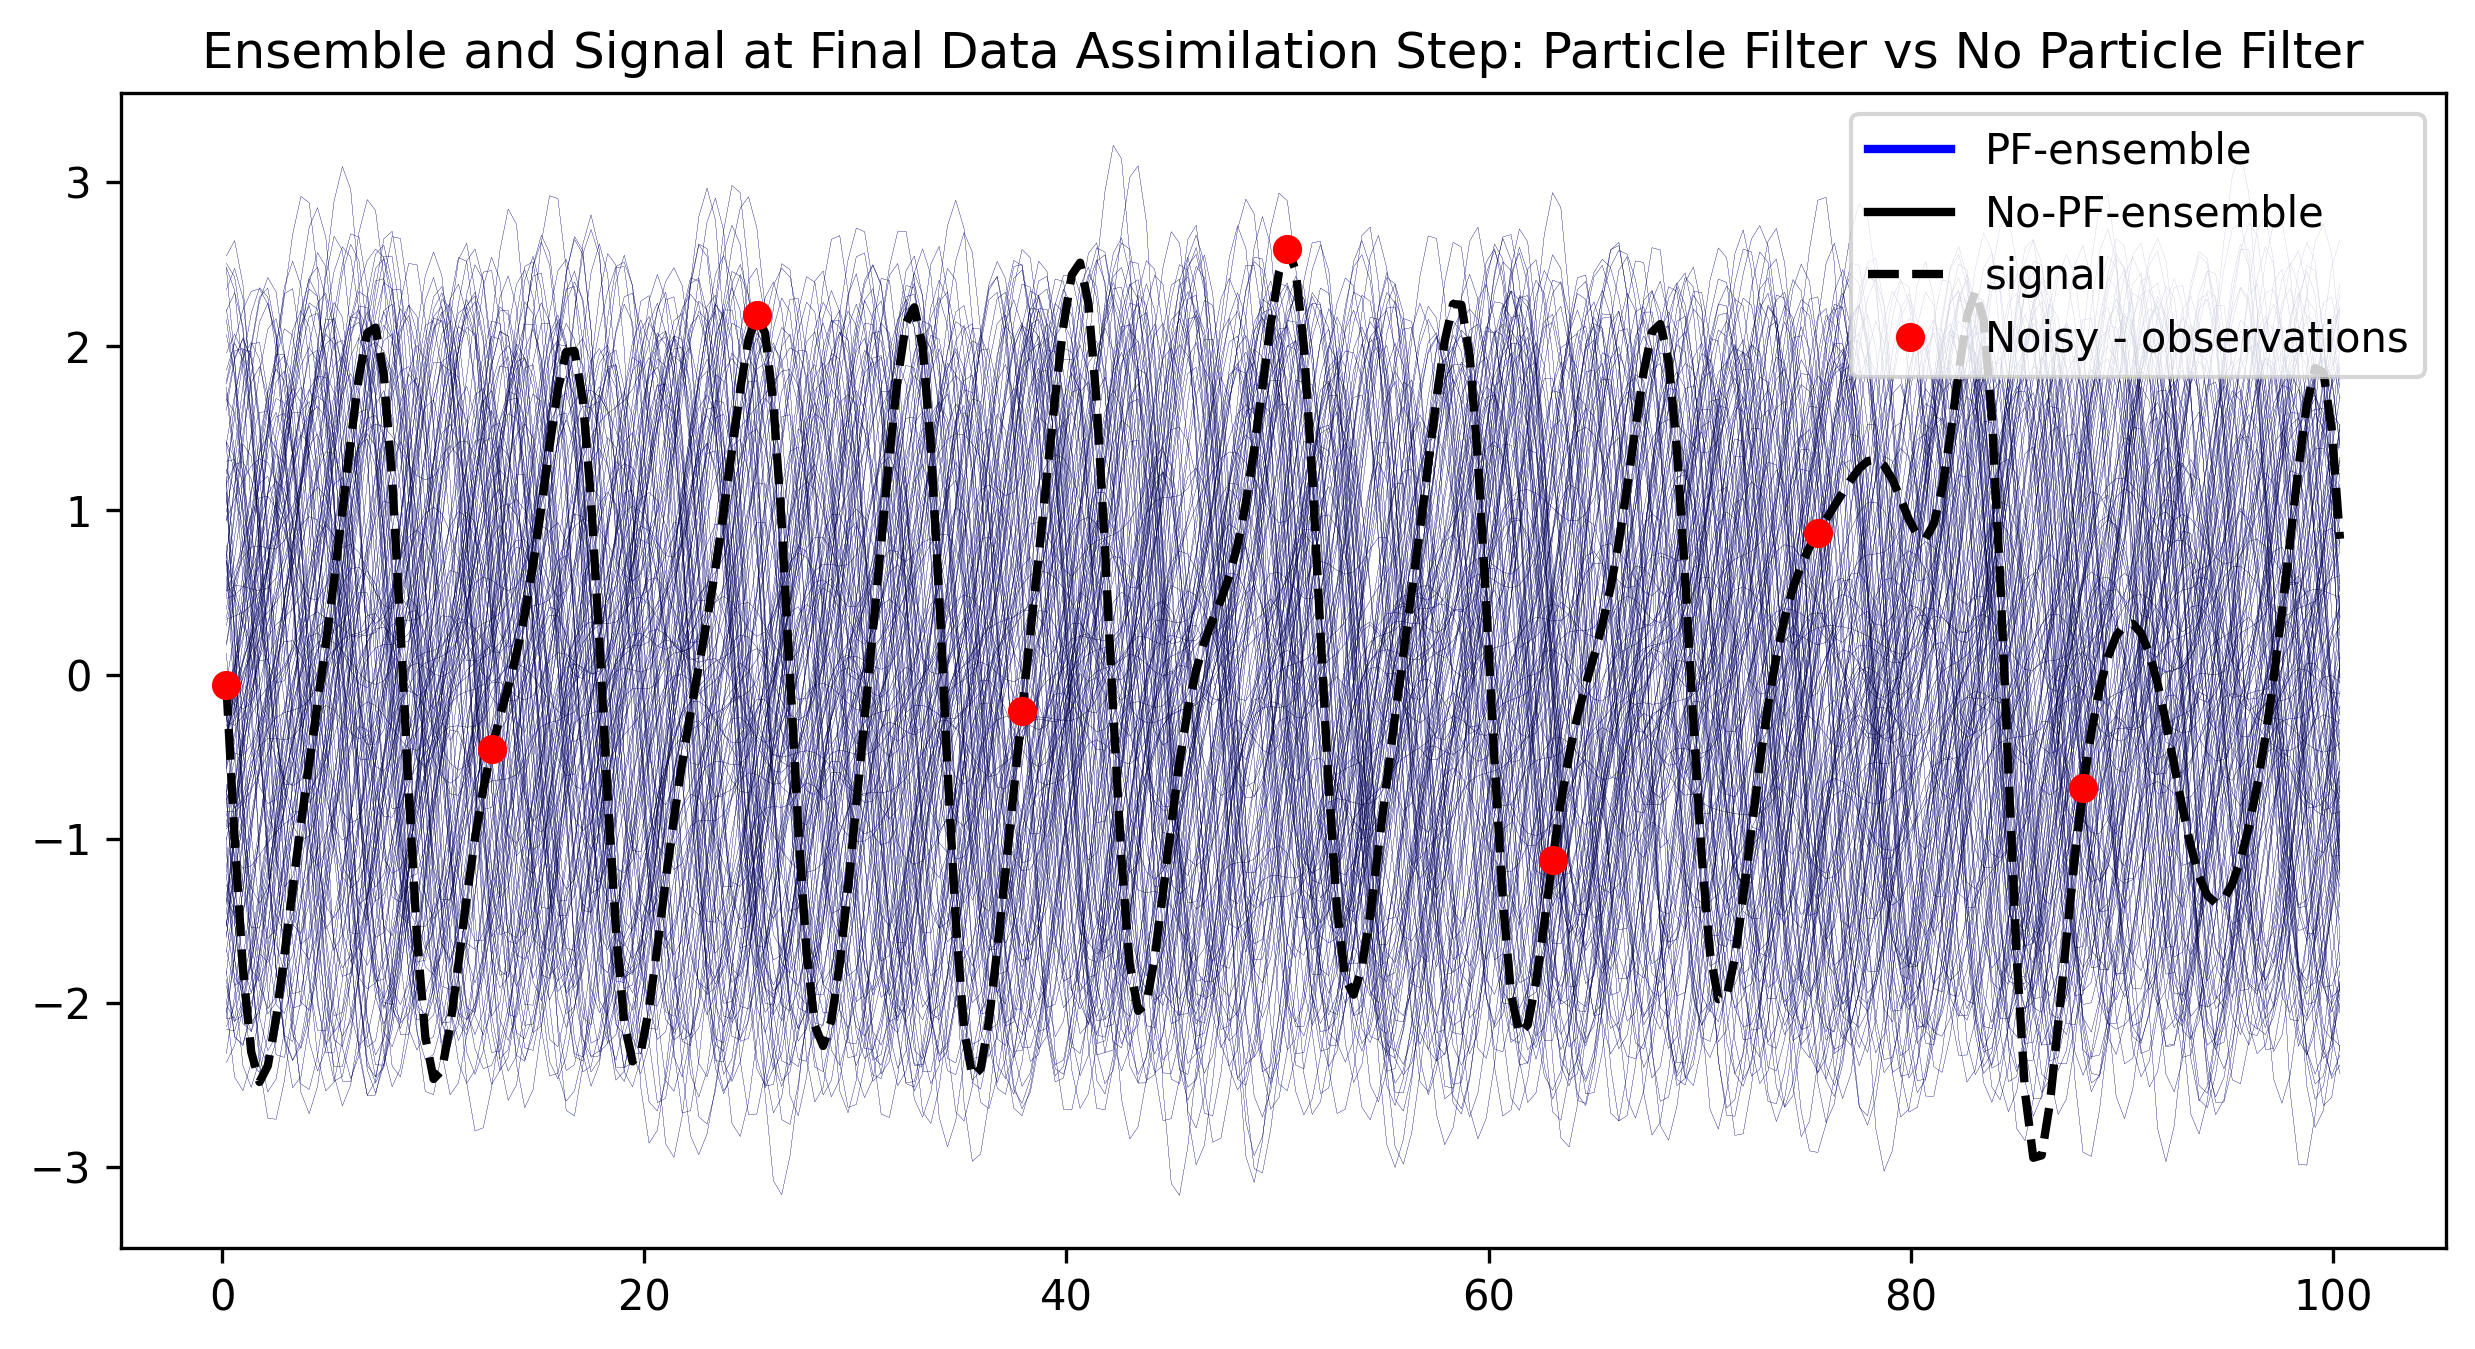

In [11]:
da_step = da_steps  # Only plot at the final DA stage
plt.figure(figsize=(10, 5),dpi=300)
plt.plot(signal_model.x, particles[da_step,:,:].T, color='b', linewidth=0.05)
#plt.plot(signal_model.x, particles[da_step,0,:].T, color='b', label='PF-ensemble', linewidth=0.1)
# Plot invisible lines for legend with desired linewidths
plt.plot([], [], color='b', label='PF-ensemble', linewidth=2)
plt.plot([], [], color='k', label='No-PF-ensemble', linewidth=2)
plt.plot(signal_model.x, signal[da_step,0,:], color='k', label='signal',linewidth=2,linestyle='--')  
plt.plot(signal_model.x, particles_1[da_step,:,:].T, color='k', linewidth=0.05)
#plt.plot(signal_model.x, particles_1[da_step,0,:].T, color='k', label='No-PF-ensemble', linewidth=0.1)
for i, obs_idx in enumerate(observation_locations):
    plt.vlines(
        x=signal_model.x[obs_idx],
        ymin=observations[da_step-1, 0, i],
        ymax=signal[da_step, 0, obs_idx],
        color='red',
        linewidth=2,
        alpha=0.7
    )
plt.plot(signal_model.x[observation_locations], observations[da_step-1,0,:], 'ro', label='Noisy - observations')
plt.legend()
plt.title('Ensemble and Signal at Final Data Assimilation Step: Particle Filter vs No Particle Filter')
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/KS_PF_NPF.png',bbox_inches='tight',dpi=300)
plt.show()

(33, 128, 256)
(33, 1, 256)


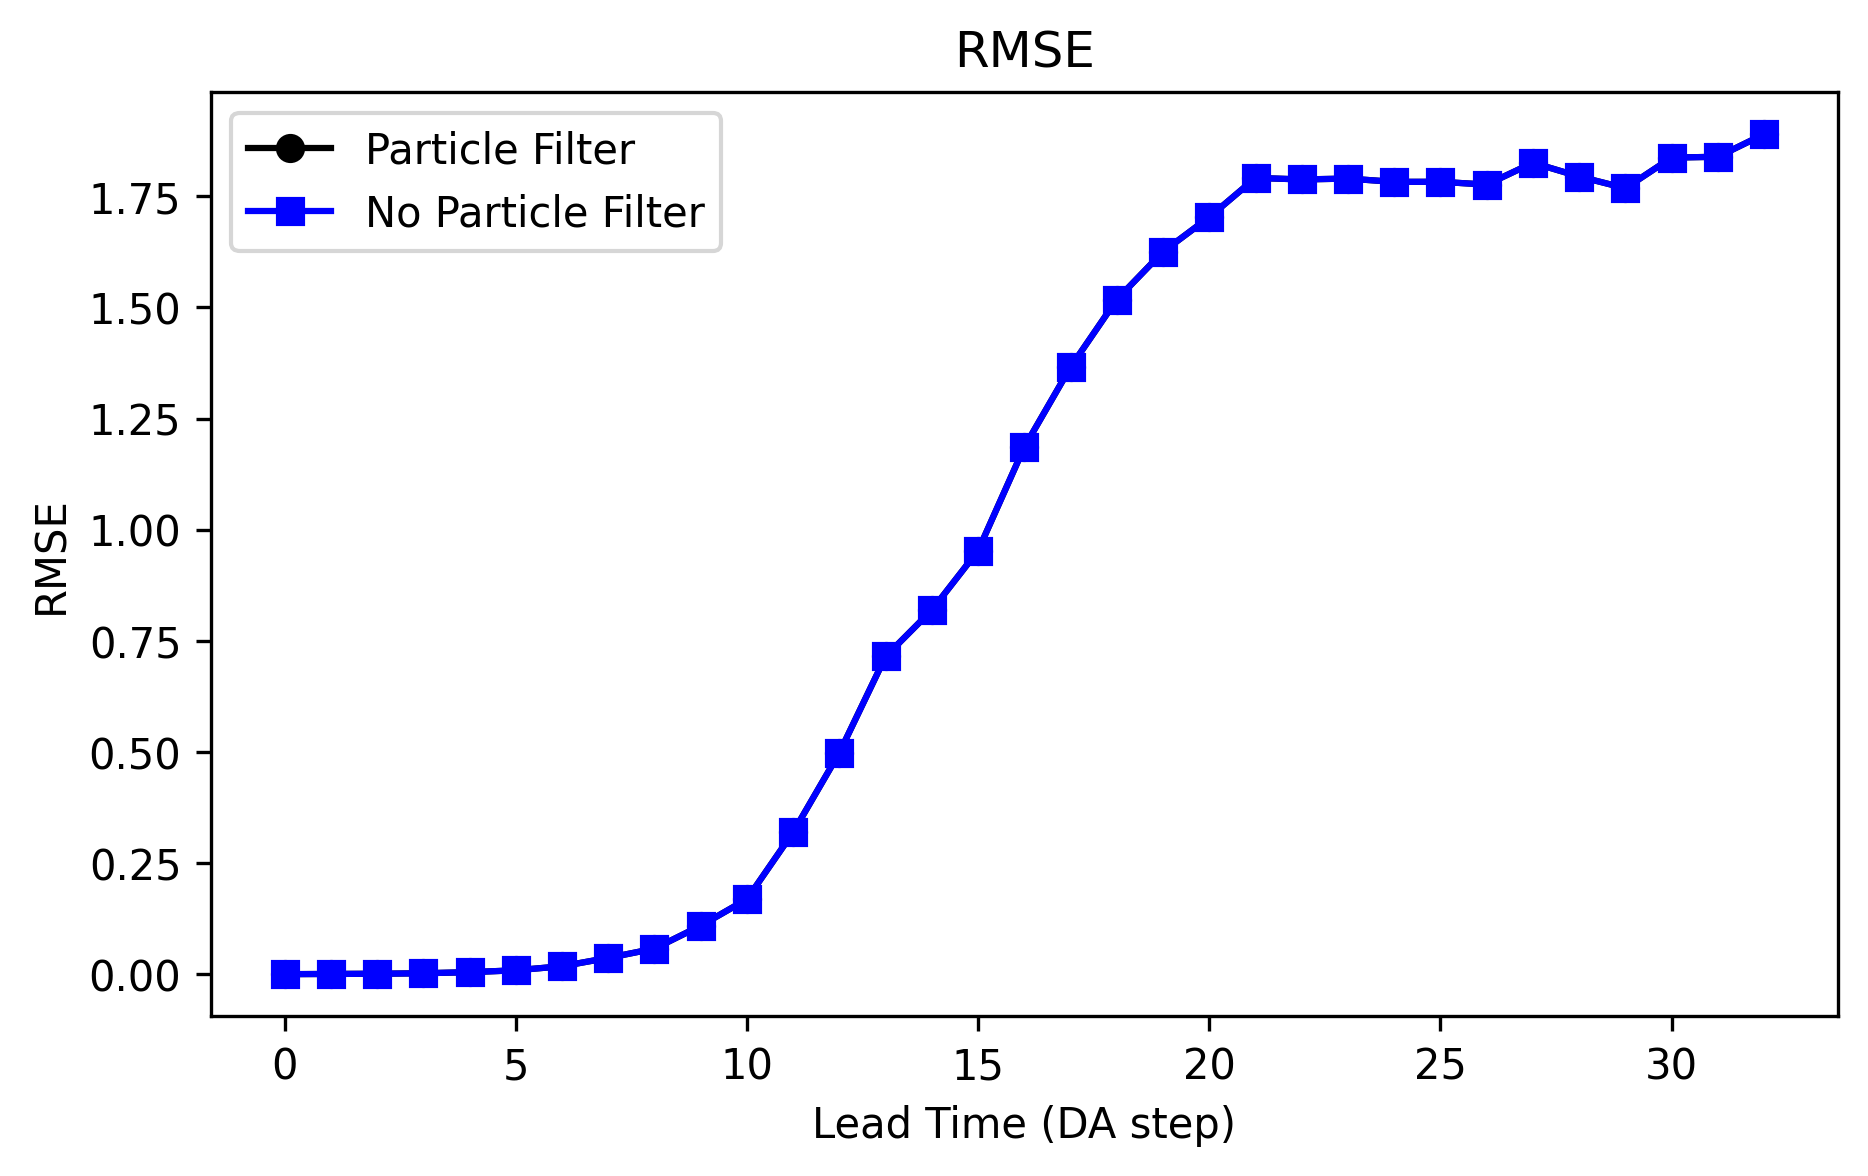

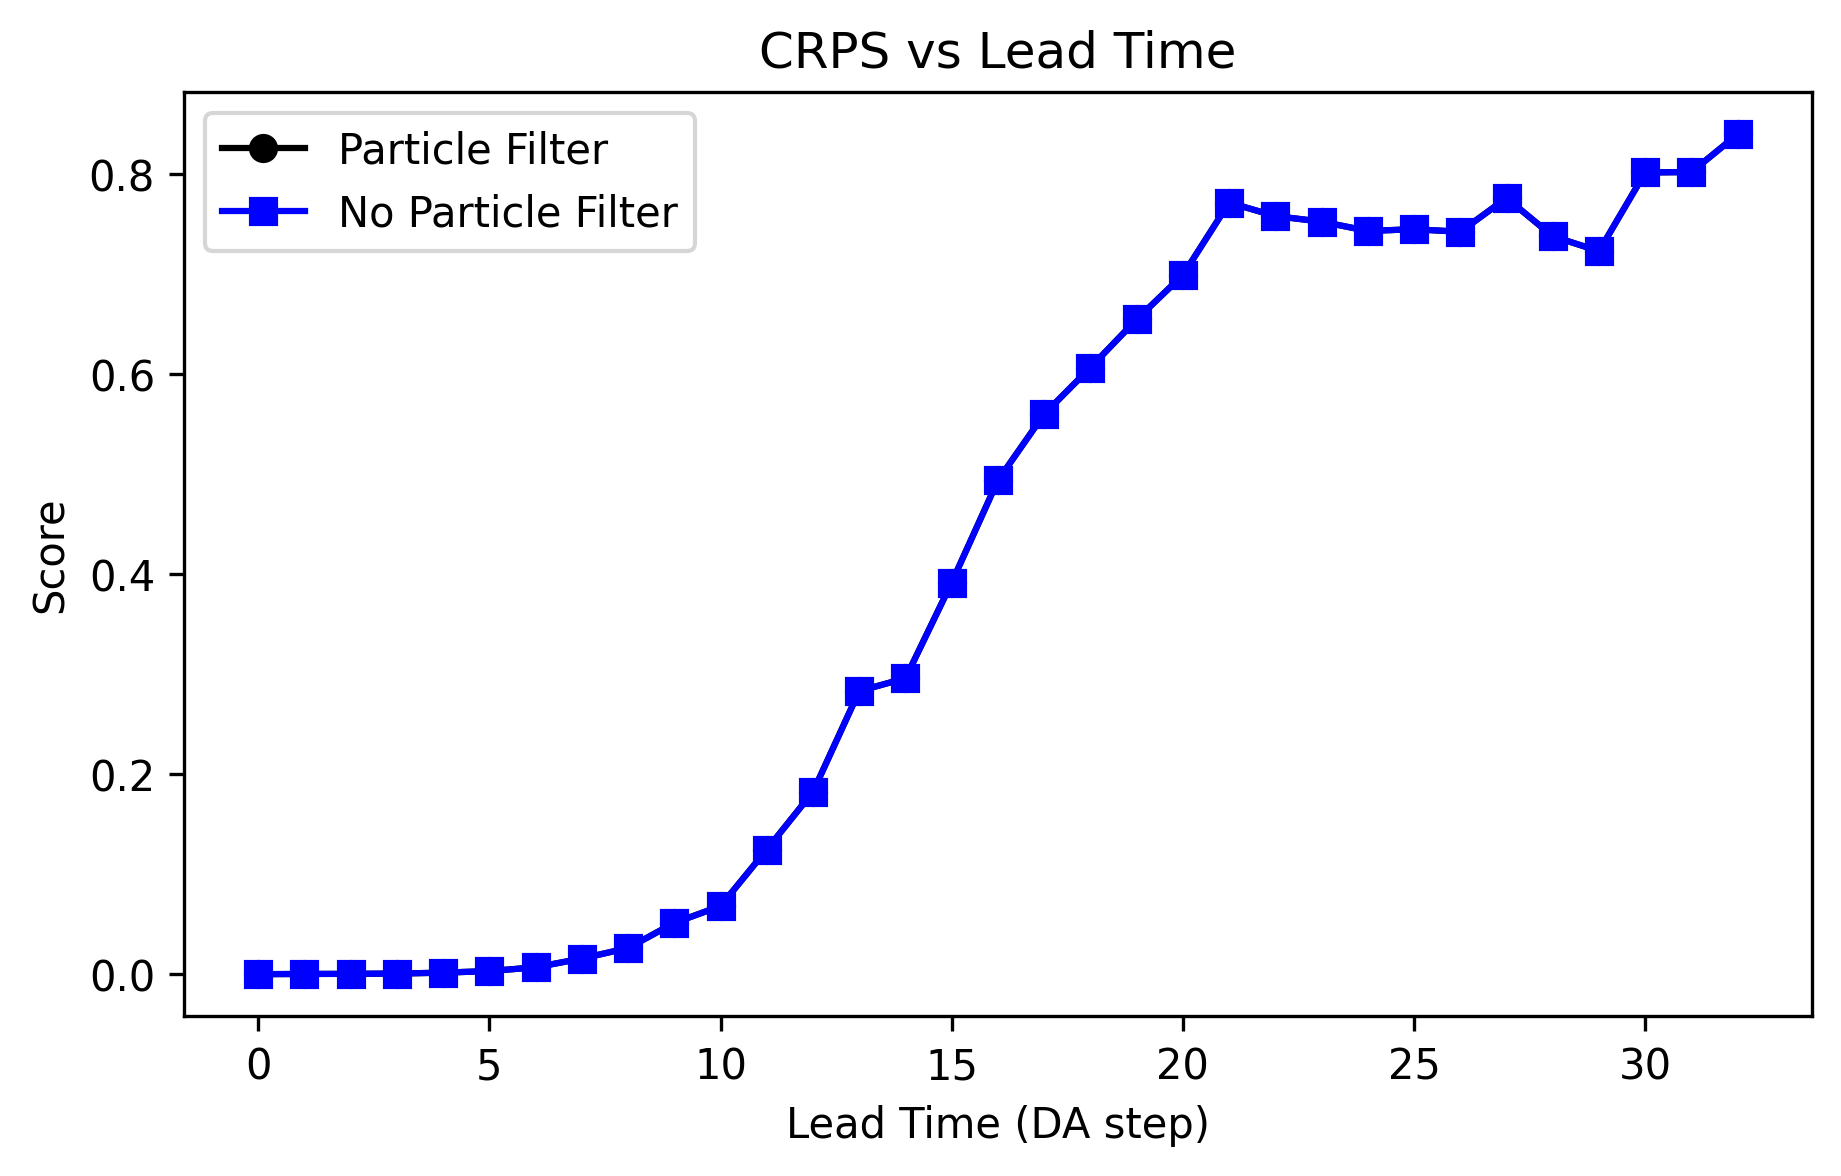

In [12]:
from metrics.ensemble import rmse, crps, bias

# Compute RMSE between signal and particle ensemble mean
print(particles.shape)
print(signal.shape)
rmse_score = rmse(signal[:,:,:], particles)
# Compute CRPS between signal and particles
crps_score = crps(signal[:,:,:], particles)

rmse_score_1 = rmse(signal[:,:,:], particles_1)
# Compute CRPS between signal and particles
crps_score_1 = crps(signal[:,:,:], particles_1)

dpi=300
plt.figure(figsize=(7, 4), dpi=dpi)
plt.plot(np.arange(da_steps + 1), rmse_score, color='black', marker='o', label='Particle Filter')
plt.plot(np.arange(da_steps + 1), rmse_score_1, color='blue', marker='s', label='No Particle Filter')
plt.xlabel('Lead Time (DA step)')
plt.ylabel('RMSE')
plt.title('RMSE')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4), dpi=dpi)
plt.plot(np.arange(da_steps + 1), crps_score, color='black', marker='o', label='Particle Filter')
plt.plot(np.arange(da_steps + 1), crps_score_1, color='blue', marker='s', label='No Particle Filter')
plt.xlabel('Lead Time (DA step)')
plt.ylabel('Score')
plt.title('CRPS vs Lead Time')
plt.legend()
plt.show()